### Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import confusion_matrix

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Initialize the Spark Context

In [2]:
# Use findspark.init() to locate spark on the system and import the library for you.
# If you don't do this step, you might face an issue of python worker failed to connect.
findspark.init()

# Start the Spark session
spark = SparkSession.builder.appName("ClassImbalanceHandling").getOrCreate()

## Create Mock Pyspark Dataset with Class Imbalance

In [3]:
# Define the number of samples
total_samples = 100000

# Define the features (e.g., you can choose any distribution for feature values)
# In this example, we use random values from normal distribution
np.random.seed(0)
feature1 = np.random.normal(0, 1000, total_samples)
feature2 = np.random.normal(0, 1, total_samples)
feature3 = np.random.normal(0, 100, total_samples)
feature4 = np.random.normal(0, 1, total_samples)
feature5 = np.random.normal(0, 10, total_samples)

# Create the dataset
data = {
    "col1": feature1,
    "col2": feature2,
    "col3": feature3,
    "col4": feature4,
    "col5": feature5
}

# Create a pandas DataFrame with the dictionary
df = pd.DataFrame(data)

# Introduce class imbalance by assigning one class more samples
# In this example, Class A has the majority and Class B has the minority
# You can adjust the imbalance ratio as needed
imbalance_ratio = 0.05  # 5% Class B samples
class_b_samples = int(total_samples * imbalance_ratio)
total_class_b_samples = - class_b_samples
print(f"There are total of {-total_class_b_samples} Class B samples.")

# Add in the "class" column with the labels
df['class'] = 'A'
df.iloc[total_class_b_samples:,5] = 'B'

# Shuffle the dataset to mix the classes (not that it makes a difference but just for demo.)
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Show the 1st 5 rows.
print(df.head())

There are total of 5000 Class B samples.
          col1      col2        col3      col4       col5 class
0 -1718.649877  0.898257  -39.836576 -0.198589   5.539138     A
1  -121.041019 -0.444813    3.686693 -0.558107  -6.573311     A
2  1038.512670  0.783736   42.352528  0.450083  13.525636     A
3  -209.312628 -2.215415   36.416854  1.678712  12.133693     A
4  -429.805510 -1.292846 -237.993497 -0.564347  16.672520     A


In [4]:
# Check to see if there are the correct number of rows with Class B
print(df.loc[df['class']=='B'].count())

col1     5000
col2     5000
col3     5000
col4     5000
col5     5000
class    5000
dtype: int64


In [5]:
# Define the schema for the PySpark DataFrame
schema = StructType([
    StructField("Feature1", DoubleType(), True),
    StructField("Feature2", DoubleType(), True),
    StructField("Feature3", DoubleType(), True),
    StructField("Feature4", DoubleType(), True),
    StructField("Feature5", DoubleType(), True),
    StructField("Class", StringType(), True)
])

# Convert the pandas DataFrame to PySpark DataFrame
pyspark_df = spark.createDataFrame(df, schema=schema)

In [6]:
# Show the first few rows of the PySpark DataFrame
pyspark_df.show()

+-------------------+--------------------+-------------------+--------------------+-------------------+-----+
|           Feature1|            Feature2|           Feature3|            Feature4|           Feature5|Class|
+-------------------+--------------------+-------------------+--------------------+-------------------+-----+
| -1718.649876612095|  0.8982566006303742| -39.83657612644435|-0.19858908539429249|  5.539138272731238|    A|
|-121.04101922277877| -0.4448128444740752| 3.6866931235569558| -0.5581070764909885| -6.573310665724776|    A|
|  1038.512669661264|  0.7837362000748797| 42.352528263407955| 0.45008269775923704| 13.525636175411687|    A|
|-209.31262765761383|  -2.215414966767953| 36.416853544786235|  1.6787123778283846| 12.133693494115981|    A|
|-429.80551004065086| -1.2928462486265264|-237.99349743855237| -0.5643467373641192|  16.67251969166381|    A|
| -1330.663464004668|  0.7637053829834995| -78.96444127988173| -1.2669440573794475|   3.51228852908923|    A|
|   847.29

In [7]:
pyspark_df.printSchema()

root
 |-- Feature1: double (nullable = true)
 |-- Feature2: double (nullable = true)
 |-- Feature3: double (nullable = true)
 |-- Feature4: double (nullable = true)
 |-- Feature5: double (nullable = true)
 |-- Class: string (nullable = true)



### Use the creditcard.csv

In [8]:
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("PC1", DoubleType(), True),
    StructField("PC2", DoubleType(), True),
    StructField("PC3", DoubleType(), True),
    StructField("PC4", DoubleType(), True),
    StructField("PC5", DoubleType(), True),
    StructField("Class", IntegerType(), True)
])
pyspark_df = spark.read.format('csv')\
                    .option('header',True)\
                    .schema(schema)\
                    .load('creditcard.csv')
pyspark_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- PC1: double (nullable = true)
 |-- PC2: double (nullable = true)
 |-- PC3: double (nullable = true)
 |-- PC4: double (nullable = true)
 |-- PC5: double (nullable = true)
 |-- Class: integer (nullable = true)



In [9]:
pyspark_df.filter(F.col('Class')==1).count()


180

In [10]:
pyspark_df.filter(F.col('Class')==0).count()

4520

#### Split the data into train and test

In [11]:
# Set the train/test ratio
train_test_ratio = 0.8

# Split the data into training and testing sets using stratified sampling
train_data_class_b = pyspark_df.filter(F.col('Class')=='1').sample(fraction=train_test_ratio, seed=88)
train_data_class_a = pyspark_df.filter(F.col('Class')=='0').sample(fraction=train_test_ratio, seed=88)
train_data = train_data_class_a.union(train_data_class_b)

test_data = pyspark_df.subtract(train_data)

# Print the number of samples in each set
print("Training Set Size:", train_data.count())
print("Testing Set Size:", test_data.count())
print("Class B fraction in Training Set Size:", train_data.filter(F.col('Class')=='1').count()/train_data.count())
print("Class B fraction in Test Set Size:", test_data.filter(F.col('Class')=='1').count()/test_data.count())

Training Set Size: 3784
Testing Set Size: 916
Class B fraction in Training Set Size: 0.03646934460887949
Class B fraction in Test Set Size: 0.04585152838427948


### Create a Random Forest Classifier Model
#### Prep the data by vectorizing it and stringindexing it

In [12]:
# Assemble the features into a Vector to feed the Model.
feature_list = ["PC1","PC2","PC3","PC4","PC5"]
assembler = VectorAssembler(inputCols=feature_list, outputCol='features_for_model')
model_df1 = assembler.transform(train_data)

# Convert the label from String to Numeric using a StringIndexer
indexer = StringIndexer(inputCol='Class', outputCol='label')
model_df2 = indexer.fit(model_df1).transform(model_df1)

In [13]:
# To see what model_df looks like (after Vector Assembler)
model_df1.toPandas().head()

,ID,PC1,PC2,PC3,PC4,PC5,Class,features_for_model
0,1,-56.875735,-29.555189,1.990487,0.535853,0.452358,0,"[-56.87573501, -29.55518894, 1.990486881, 0.53..."
1,2,-59.144792,-52.266486,9.616903,0.522322,-1.009143,0,"[-59.14479234, -52.2664855, 9.616902797, 0.522..."
2,4,-55.707948,-18.275413,16.567411,-0.237213,1.206393,0,"[-55.70794783, -18.2754125, 16.56741097, -0.23..."
3,5,96.888263,-49.836550,11.666317,-0.444835,-0.935363,0,"[96.88826338, -49.8365497, 11.66631704, -0.444..."
4,6,-53.126276,7.961177,-10.243002,-0.354893,0.562748,0,"[-53.12627637, 7.961176875, -10.24300161, -0.3..."


In [14]:
# To see what model_df looks like (after StringIndexer) - Where Class = 0
model_df2.filter(F.col('Class')==0).toPandas().head()

,ID,PC1,PC2,PC3,PC4,PC5,Class,features_for_model,label
0,1,-56.875735,-29.555189,1.990487,0.535853,0.452358,0,"[-56.87573501, -29.55518894, 1.990486881, 0.53...",0.0
1,2,-59.144792,-52.266486,9.616903,0.522322,-1.009143,0,"[-59.14479234, -52.2664855, 9.616902797, 0.522...",0.0
2,4,-55.707948,-18.275413,16.567411,-0.237213,1.206393,0,"[-55.70794783, -18.2754125, 16.56741097, -0.23...",0.0
3,5,96.888263,-49.836550,11.666317,-0.444835,-0.935363,0,"[96.88826338, -49.8365497, 11.66631704, -0.444...",0.0
4,6,-53.126276,7.961177,-10.243002,-0.354893,0.562748,0,"[-53.12627637, 7.961176875, -10.24300161, -0.3...",0.0


In [15]:
# To see what model_df looks like (after StringIndexer) - Where Class = 1
model_df2.filter(F.col('Class')==1).toPandas().head()

,ID,PC1,PC2,PC3,PC4,PC5,Class,features_for_model,label
0,2610,-50.079684,38.071020,-2.484333,1.845887,-0.877830,1,"[-50.07968427, 38.07101971, -2.484332666, 1.84...",1.0
1,2612,-47.268010,65.950089,-0.339218,-0.135063,-0.750094,1,"[-47.26801012, 65.9500888, -0.339218025, -0.13...",1.0
2,2656,478.495943,77.750641,-28.507607,0.599897,-0.632535,1,"[478.4959434, 77.75064085, -28.50760678, 0.599...",1.0
3,2668,255.421958,67.612600,-0.365628,-2.613926,0.825994,1,"[255.4219576, 67.61260005, -0.365627643, -2.61...",1.0
4,2670,-48.237714,56.611720,-14.262100,-1.983010,-0.695295,1,"[-48.23771432, 56.61172029, -14.26209973, -1.9...",1.0


In [16]:
def preprocess_data(df):
    # Assemble the features into a Vector to feed the Model.
    feature_list = ["PC1","PC2","PC3","PC4","PC5"]
    assembler = VectorAssembler(inputCols=feature_list, outputCol='features_for_model')
    model_df1 = assembler.transform(df)

    # Convert the label from String to Numeric using a StringIndexer
    indexer = StringIndexer(inputCol='Class', outputCol='label')
    model_df2 = indexer.fit(model_df1).transform(model_df1)
    
    return model_df2

def train_model(train_df, smote=0):
    if smote == 0:
        model_df = preprocess_data(train_df)
    elif smote == 1:
        model_df = train_df
    
    # Initiate the Random Forest Classifier Model
    rf = RandomForestClassifier(featuresCol='features_for_model', labelCol='label', seed=88)
    rf_model = rf.fit(model_df)
    
    return rf_model

def test_model(test_df, model):
    model_df = preprocess_data(test_df)
    
    prediction = model.transform(model_df)
    
    return prediction

In [17]:
# Initiate the Random Forest Classifier Model
rf_model = train_model(train_data)

In [18]:
# Test the Model
prediction = test_model(test_data, rf_model)

# To see what the output looks like. There will be additional columns.
# rawPrediction, probability, prediction
print(prediction.toPandas().head())

     ID        PC1         PC2        PC3       PC4       PC5  Class  \
0   727 -56.935983  -29.878792 -10.735008 -0.233838  0.484281      0   
1  1857 -42.351534  115.220109 -19.933270 -1.546045  0.820138      0   
2  3075 -51.464295   24.184253   2.798403 -1.198078 -0.085652      0   
3  3683 -50.929984   29.367443   9.043517  1.190360  0.541220      1   
4  3950 -54.929487   -9.968973  -9.808559 -1.371793 -0.849817      0   

                                  features_for_model  label  \
0  [-56.93598264, -29.87879217, -10.7350075, -0.2...    0.0   
1  [-42.35153363, 115.220109, -19.93326977, -1.54...    0.0   
2  [-51.46429473, 24.18425294, 2.798403104, -1.19...    0.0   
3  [-50.92998423, 29.36744284, 9.043517166, 1.190...    1.0   
4  [-54.92948737, -9.968972732, -9.808558912, -1....    0.0   

                               rawPrediction  \
0  [19.98801086803672, 0.011989131963278768]   
1    [15.638830851400103, 4.361169148599899]   
2  [19.858037000836156, 0.14196299916384544]

In [19]:
# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')
auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

print(f"AUROC: {auroc}")
print(f"AUPR: {aupr}")

AUROC: 0.9282309033453198
AUPR: 0.36244362221306214


In [20]:
# Evaluate using MultiClass Metrics
pred_rdd = prediction.select('prediction','label').rdd.map(tuple)
metrics = MulticlassMetrics(pred_rdd)
accuracy_o = metrics.accuracy   # Positive class
precision_o = metrics.precision(1.0)  # Positive class
recall_o = metrics.recall(1.0)  # Positive class
f1_o = metrics.fMeasure(1.0)  # Positive class

print("Accuracy:", accuracy_o)
print("Precision:", precision_o)
print("Recall:", recall_o)
print("F1-score:", f1_o)

C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.9563318777292577
Precision: 1.0
Recall: 0.047619047619047616
F1-score: 0.0909090909090909


DenseMatrix([[874.,   0.],
             [ 40.,   2.]])


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\1843384171.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\1843384171.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


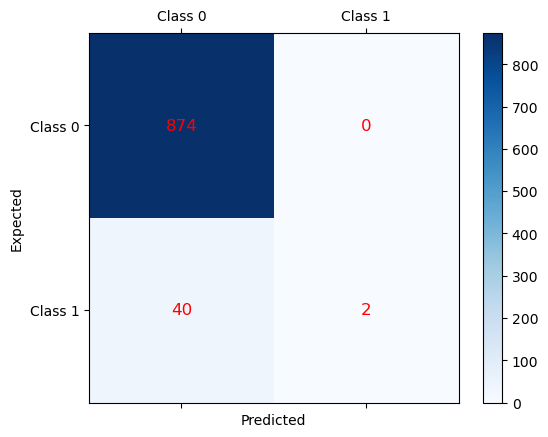

In [21]:
# Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
# Meaning 0 1 in columns. Rows also 0 then 1.
print(metrics.confusionMatrix())

confusion_matrix = metrics.confusionMatrix().toArray()
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
# Add actual values to the cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()


In [22]:
# Traditional way to evaluate TN/TP/FP/FN
# Countercheck with confusion matrix above.
tn = prediction.filter((F.col('label')==0)&(F.col('prediction')==0)).count()
tp = prediction.filter((F.col('label')==1)&(F.col('prediction')==1)).count()
fp = prediction.filter((F.col('label')==0)&(F.col('prediction')==1)).count()
fn = prediction.filter((F.col('label')==1)&(F.col('prediction')==0)).count()

print(f"TN: {tn}")
print(f"TP: {tp}")
print(f"FP: {fp}")
print(f"FN: {fn}")

TN: 874
TP: 2
FP: 0
FN: 40


Based on the above information, it is very clear that even though there is a high accuracy, the high accuracy is derived from the high amount of True Negatives.
Formula for Accuracy is (TP+TN) / (TP+TN+FP+FN)
We want to correctly predict class B and we want to get as high of a True Positive as we can.
We are currently getting 0 True Positives so the model is not working at all.

### Undersampling Majority

In [23]:
# Create undersampling function
def undersample_majority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(F.col('class')==1).count()
    whole_count = df.count()
    undersampled_majority = df.filter(F.col('class')==0)\
                                .sample(withReplacement=False, fraction=(ratio*minority_count/whole_count),seed=88)
    undersampled_df = df.filter(F.col('class')==1).union(undersampled_majority)
    
    return undersampled_df

In [24]:
# Create evaluation function
def evaluate_test_data(test_df, model):
    model_df = preprocess_data(test_df)
    prediction = model.transform(model_df)
    
    # Evaluate the model using a BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol='label')
    auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
    aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

    print(f"AUROC: {auroc}")
    print(f"AUPR: {aupr}")
    
    # Evaluate using MultiClass Metrics
    pred_rdd = prediction.select('prediction','label').rdd.map(tuple)
    metrics = MulticlassMetrics(pred_rdd)
    accuracy_o = metrics.accuracy   # Positive class
    precision_o = metrics.precision(1.0)  # Positive class
    recall_o = metrics.recall(1.0)  # Positive class
    f1_o = metrics.fMeasure(1.0)  # Positive class

    print("Accuracy:", accuracy_o)
    print("Precision:", precision_o)
    print("Recall:", recall_o)
    print("F1-score:", f1_o)
    
    confusion_matrix = metrics.confusionMatrix().toArray()
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    # Add actual values to the cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    # Traditional way to evaluate TN/TP/FP/FN
    # Countercheck with confusion matrix above.
    tn = prediction.filter((F.col('label')==0)&(F.col('prediction')==0)).count()
    tp = prediction.filter((F.col('label')==1)&(F.col('prediction')==1)).count()
    fp = prediction.filter((F.col('label')==0)&(F.col('prediction')==1)).count()
    fn = prediction.filter((F.col('label')==1)&(F.col('prediction')==0)).count()

    print(f"TN: {tn}")
    print(f"TP: {tp}")
    print(f"FP: {fp}")
    print(f"FN: {fn}")
    
    

AUROC: 0.08808706548981148
AUPR: 0.024684265955264798


C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.22489082969432314
Precision: 0.0
Recall: 0.0
F1-score: 0.0


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


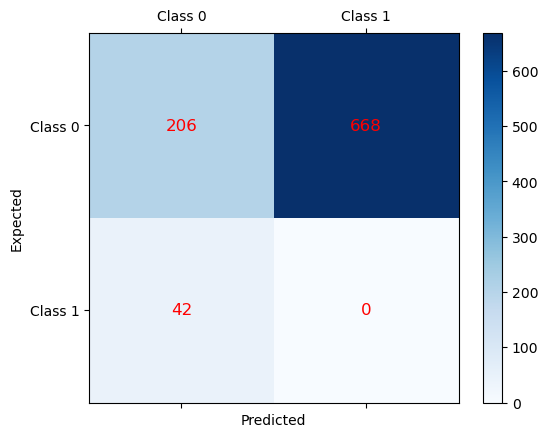

TN: 206
TP: 0
FP: 668
FN: 42


In [25]:
# Evaluate Undersampling 1:1
undersampled_train_df_1_1 = undersample_majority(train_data,1)
rf_model1 = train_model(undersampled_train_df_1_1)
evaluate_test_data(test_data, rf_model1)

AUROC: 0.9185463659147869
AUPR: 0.2207557575315765


C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8275109170305677
Precision: 0.20103092783505155
Recall: 0.9285714285714286
F1-score: 0.3305084745762712


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


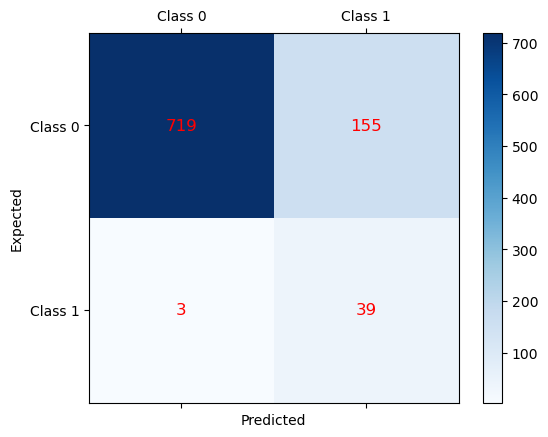

TN: 719
TP: 39
FP: 155
FN: 3


In [26]:
# Evaluate Undersampling 1:2
undersampled_train_df_1_2 = undersample_majority(train_data,2)
rf_model2 = train_model(undersampled_train_df_1_2)
evaluate_test_data(test_data, rf_model2)

AUROC: 0.9148005884275906
AUPR: 0.21517514062693147


C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.888646288209607
Precision: 0.25
Recall: 0.7142857142857143
F1-score: 0.37037037037037035


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


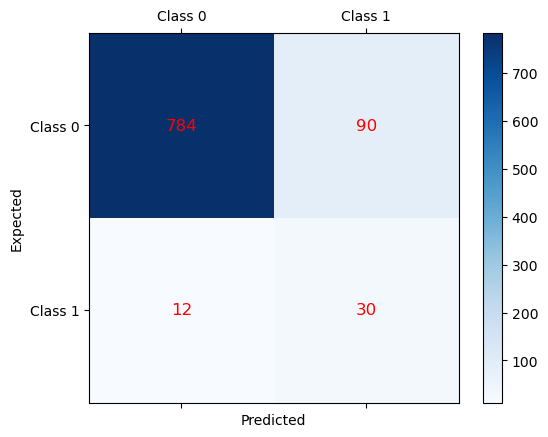

TN: 784
TP: 30
FP: 90
FN: 12


In [27]:
# Evaluate Undersampling 1:5
undersampled_train_df_1_5 = undersample_majority(train_data,5)
rf_model3 = train_model(undersampled_train_df_1_5)
evaluate_test_data(test_data, rf_model3)

### Oversampling Minority

In [28]:
# Create undersampling function
def oversample_minority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(F.col('class')==1).count()
    majority_count = df.filter(F.col('class')==0).count()
    
    balance_ratio = majority_count / minority_count
    
    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")
    if ratio >= balance_ratio:
        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
    else:
        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")
    
    oversampled_minority = df.filter(F.col('class')==1)\
                                .sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
    oversampled_df = df.filter(F.col('class')==0).union(oversampled_minority)
    
    return oversampled_df

Initial Majority:Minority ratio is 26.42:1
Oversampling of minority done such that Majority:Minority ratio is 1:1
AUROC: 0.9120627656096764
AUPR: 0.2678383418518252


C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8668122270742358
Precision: 0.22602739726027396
Recall: 0.7857142857142857
F1-score: 0.35106382978723405


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


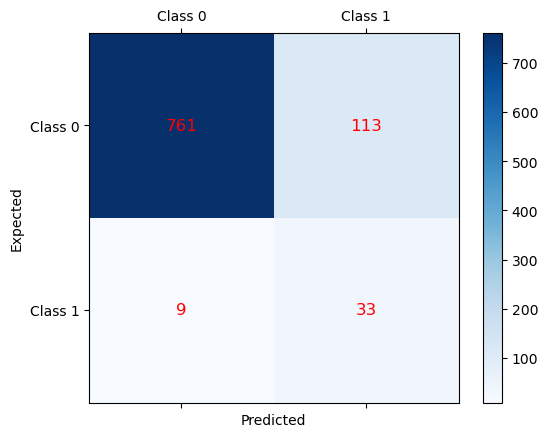

TN: 761
TP: 33
FP: 113
FN: 9


In [29]:
# Train 3 different oversamplings
# Evaluate Oversampling 1:1
oversampled_train_df_1_1 = oversample_minority(train_data,1)
rf_model4 = train_model(oversampled_train_df_1_1)
evaluate_test_data(test_data, rf_model4)

Initial Majority:Minority ratio is 26.42:1
Oversampling of minority done such that Majority:Minority ratio is 2:1
AUROC: 0.9074043805165087
AUPR: 0.21591344273582252


C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8733624454148472
Precision: 0.22388059701492538
Recall: 0.7142857142857143
F1-score: 0.34090909090909094


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


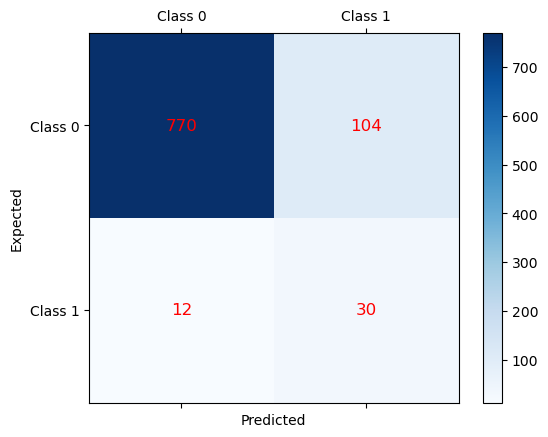

TN: 770
TP: 30
FP: 104
FN: 12


In [30]:
# Evaluate Oversampling 1:2
oversampled_train_df_1_2 = oversample_minority(train_data,2)
rf_model5 = train_model(oversampled_train_df_1_2)
evaluate_test_data(test_data, rf_model5)

Initial Majority:Minority ratio is 26.42:1
Oversampling of minority done such that Majority:Minority ratio is 5:1
AUROC: 0.9201808870001089
AUPR: 0.2822229042105263


C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8842794759825328
Precision: 0.23770491803278687
Recall: 0.6904761904761905
F1-score: 0.35365853658536583


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


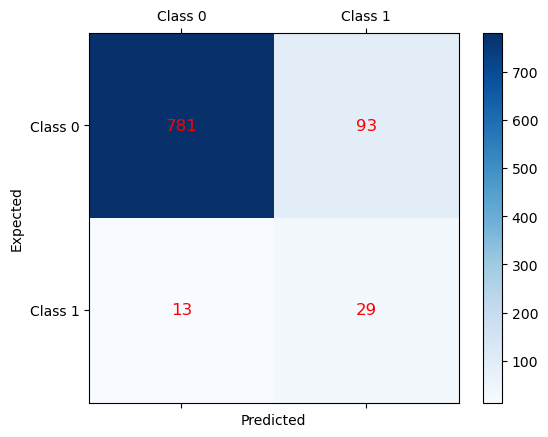

TN: 781
TP: 29
FP: 93
FN: 13


In [31]:
# Evaluate Oversampling 1:5
oversampled_train_df_1_5 = oversample_minority(train_data,5)
rf_model6 = train_model(oversampled_train_df_1_5)
evaluate_test_data(test_data, rf_model6)

### Oversampling using SMOTE (Synthetic Minority Over-Sampling Technique)

In [32]:
## Used the code from below:
## https://medium.com/@hwangdb/smote-implementation-in-pyspark-76ec4ffa2f1d
## https://gist.github.com/hwang018/420e288021e9bdacd133076600a9ea8c
## https://gist.github.com/inguelberth/547db5aef8fb82527c79b1d6e2fc368c

import random
import numpy as np
from functools import reduce
from pyspark.sql import DataFrame, SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.functions import array, create_map, struct, rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql.window import Window
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, LongType
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer,StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector, DenseVector
from pyspark.ml import Pipeline

def pre_smote_df_process(df,num_cols,cat_cols,target_col,index_suffix="_index"):
    '''
    string indexer and vector assembler
    inputs:
    * df: spark df, original
    * num_cols: numerical cols to be assembled
    * cat_cols: categorical cols to be stringindexed
    * target_col: prediction target
    * index_suffix: will be the suffix after string indexing
    output:
    * vectorized: spark df, after stringindex and vector assemble, ready for smote
    '''
    if(df.select(target_col).distinct().count() != 2):
         raise ValueError("Target col must have exactly 2 classes")
        
    if target_col in num_cols:
        num_cols.remove(target_col)

    # only assembled numeric columns into features
    assembler = VectorAssembler(inputCols = num_cols, outputCol = 'features_for_model')
    # index the string cols, except possibly for the label col
    assemble_stages = [StringIndexer(inputCol=column, outputCol=column+index_suffix) for column in list(set(cat_cols)-set([target_col]))]
    # add the stage of numerical vector assembler
    assemble_stages.append(assembler)
    pipeline = Pipeline(stages=assemble_stages)
    pos_vectorized = pipeline.fit(df).transform(df)
    
    # drop original num cols and cat cols
    drop_cols = num_cols+cat_cols
    
    keep_cols = [a for a in pos_vectorized.columns if a not in drop_cols]
    
    vectorized = pos_vectorized.select(*keep_cols).withColumn('label',pos_vectorized[target_col]).drop(target_col)
    
    return vectorized

def subtract_vector_fn(arr):
    a = arr[0]
    b = arr[1]
    
    if isinstance(a, SparseVector):
        a = a.toArray()
        
    if isinstance(b, SparseVector):
        b = b.toArray()
    
    return DenseVector(random.uniform(0, 1)*(a-b))
    
def add_vector_fn(arr):
    a = arr[0]
    b = arr[1]
    
    if isinstance(a, SparseVector):
        a = a.toArray()
        
    if isinstance(b, SparseVector):
        b = b.toArray()
    
    return DenseVector(a+b)

def smote(vectorized_sdf,smote_config):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: cat cols are already stringindexed, num cols are assembled into 'features' vector
      df target col should be 'label'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    dataInput_min = vectorized_sdf[vectorized_sdf['label'] == smote_config.positive_label]
    dataInput_maj = vectorized_sdf[vectorized_sdf['label'] == smote_config.negative_label]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features_for_model", outputCol="hashes",seed=int(smote_config.seed),\
                                      bucketLength=float(smote_config.bucketLength))
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)

    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float('inf'), distCol="EuclideanDistance")

    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")

    self_similarity_df = self_join_w_distance.withColumn("r_num", F.row_number().over(over_original_rows))

    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= int(smote_config.k))

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = F.udf(subtract_vector_fn, VectorUDT())
    add_vector_udf = F.udf(add_vector_fn, VectorUDT())
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(int(smote_config.multiplier)):
        print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected\
                            .withColumn("rand", F.rand())\
                            .withColumn('max_rand', F.max('rand').over(over_original_rows_no_order))\
                            .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel\
            .select('*', subtract_vector_udf(F.array('datasetA.features_for_model', 'datasetB.features_for_model')).alias('vec_diff'))
        df_vec_modified = df_vec_diff\
            .select('*', add_vector_udf(F.array('datasetB.features_for_model', 'vec_diff')).alias('features_for_model'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features_for_model':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c,F.col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.union, res)
    dfunion = dfunion.union(dataInput_min.select(dfunion.columns))\
        .sort(F.rand(seed=smote_config.seed))\
        .withColumn('row_number', row_number().over(Window.orderBy(lit('A'))))
    
    dataInput_maj = dataInput_maj.withColumn('row_number', row_number().over(Window.orderBy(lit('A'))))
    
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(dataInput_maj.select(dfunion.columns))
    
    return oversampled_df.sort('row_number').drop(*['row_number'])

class SmoteConfig:
    def __init__(self, seed, bucketLength, k, multiplier, positive_label, negative_label):
        self.seed = seed
        self.bucketLength = bucketLength
        self.k = k
        self.multiplier = multiplier
        self.positive_label = positive_label
        self.negative_label = negative_label

In [33]:
def wrapper_smote(config_file):
    feature_list = ["PC1","PC2","PC3","PC4","PC5"]
    smote_df = pre_smote_df_process(train_data,feature_list,[],'Class',index_suffix="_index")
    train_smoted_df = smote(smote_df, config_file)
    
    rf_model_smote = train_model(train_smoted_df,smote=1)
    return rf_model_smote

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances
generating batch 4 of synthetic instances
generating batch 5 of synthetic instances
generating batch 6 of synthetic instances
generating batch 7 of synthetic instances
generating batch 8 of synthetic instances
generating batch 9 of synthetic instances
generating batch 10 of synthetic instances
generating batch 11 of synthetic instances
generating batch 12 of synthetic instances
generating batch 13 of synthetic instances
generating batch 14 of synthetic instances
generating batch 15 of synthetic instances
generating batch 16 of synthetic instances
generating batch 17 of synthetic instances
generating batch 18 of synthetic instances
generating batch 19 of synthetic instances
generating batch 20 of synthetic instances
generating batch 21 of synthetic instances
generating batch 22 of synthetic instances
generating batch 23 o

C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8580786026200873
Precision: 0.225
Recall: 0.8571428571428571
F1-score: 0.3564356435643564


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


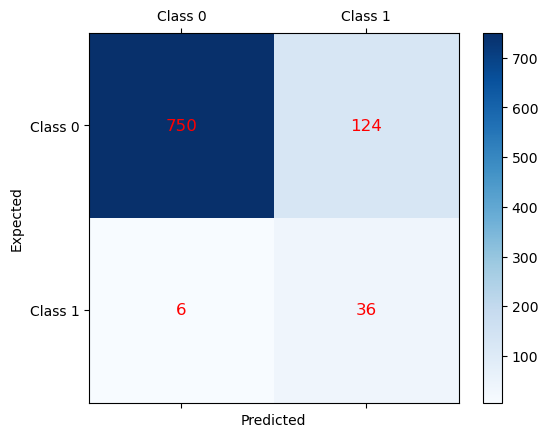

TN: 750
TP: 36
FP: 124
FN: 6


In [34]:
# Config k = 10, Multiplier = 25
config4a = SmoteConfig(76, 200, 10, 25, 1, 0)
rf_model10a = wrapper_smote(config4a)
evaluate_test_data(test_data, rf_model10a)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances
generating batch 4 of synthetic instances
generating batch 5 of synthetic instances
generating batch 6 of synthetic instances
generating batch 7 of synthetic instances
generating batch 8 of synthetic instances
generating batch 9 of synthetic instances
generating batch 10 of synthetic instances
generating batch 11 of synthetic instances
generating batch 12 of synthetic instances
generating batch 13 of synthetic instances
generating batch 14 of synthetic instances
generating batch 15 of synthetic instances
generating batch 16 of synthetic instances
generating batch 17 of synthetic instances
generating batch 18 of synthetic instances
generating batch 19 of synthetic instances
generating batch 20 of synthetic instances
generating batch 21 of synthetic instances
generating batch 22 of synthetic instances
generating batch 23 o

C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8569868995633187
Precision: 0.22012578616352202
Recall: 0.8333333333333334
F1-score: 0.34825870646766166


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


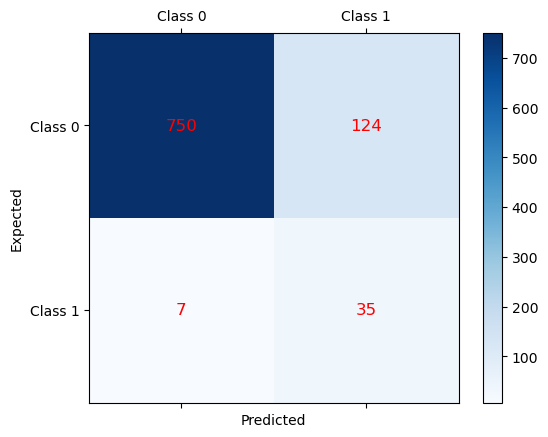

TN: 750
TP: 35
FP: 124
FN: 7


In [35]:
# Config k = 5, Multiplier = 25
config4a = SmoteConfig(76, 20, 5, 25, 1, 0)
rf_model10a = wrapper_smote(config4a)
evaluate_test_data(test_data, rf_model10a)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances
generating batch 4 of synthetic instances
generating batch 5 of synthetic instances
generating batch 6 of synthetic instances
generating batch 7 of synthetic instances
generating batch 8 of synthetic instances
generating batch 9 of synthetic instances
generating batch 10 of synthetic instances
generating batch 11 of synthetic instances
generating batch 12 of synthetic instances
generating batch 13 of synthetic instances
generating batch 14 of synthetic instances
generating batch 15 of synthetic instances
generating batch 16 of synthetic instances
generating batch 17 of synthetic instances
generating batch 18 of synthetic instances
generating batch 19 of synthetic instances
generating batch 20 of synthetic instances
generating batch 21 of synthetic instances
generating batch 22 of synthetic instances
generating batch 23 o

C:\Users\lim\.conda\envs\rip\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.8755458515283843
Precision: 0.23134328358208955
Recall: 0.7380952380952381
F1-score: 0.3522727272727273


C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\lim\AppData\Local\Temp\ipykernel_61884\2982799809.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


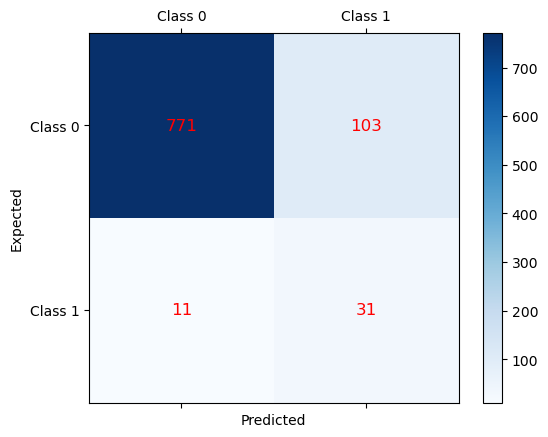

TN: 771
TP: 31
FP: 103
FN: 11


In [36]:
# Config k = 5, Multiplier = 25
config4a = SmoteConfig(76, 1, 5, 25, 1, 0)
rf_model10a = wrapper_smote(config4a)
evaluate_test_data(test_data, rf_model10a)